In [ ]:
! pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 75.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 75.6 MB/s eta 0:00:00


In [95]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

def load_features(file_path):
    with h5py.File(file_path, 'r') as hf:
        features = np.array(hf['features'])
    return features


def display_images(image_arrays):
    num_images = len(image_arrays)
    num_rows = int(np.ceil(num_images / 10))
    fig, axes = plt.subplots(num_rows, 10, figsize=(15, num_rows * 1.5))

    for i in range(num_images):
        if num_rows > 1:
            ax = axes[i // 10, i % 10]
        else:
            ax = axes[i % 10]
        ax.imshow(image_arrays[i], cmap='gray')
        ax.axis('off')

    plt.show()

syndrome_features = load_features('syndrome_features.h5')
non_syndrome_features = load_features('non_syndrome_features.h5')

syndrome_images = np.array(syndrome_features)
non_syndrome_images = np.array(non_syndrome_features)

syndrome_images = syndrome_features.reshape(-1, 1024)
non_syndrome_images = non_syndrome_features.reshape(-1, 1024)

syndrome_labels = np.ones(len(syndrome_images))
non_syndrome_labels = np.zeros(len(non_syndrome_images))

print(syndrome_images.shape)
print(non_syndrome_images.shape)

(200, 1024)
(200, 1024)


In [96]:
# Some parts of this code are based on the Python script:
# https://github.com/pytorch/tutorials/blob/master/beginner_source/transfer_learning_tutorial.py
# License: BSD

import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

torch.manual_seed(42)
np.random.seed(42)

# Plotting
import matplotlib.pyplot as plt

# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "1"

In [123]:
n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 4              # Number of samples for each training step
num_epochs = 10             # Number of training epochs
q_depth = 6                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

In [124]:
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [125]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [127]:
@qml.qnode(dev)
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

In [128]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(1024, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [129]:
# Notice that model_hybrid.fc is the last layer of ResNet18
model_hybrid = DressedQuantumNet(n_qubits)

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)

TypeError: ignored

In [134]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Assuming you have defined syndrome_images, non_syndrome_images, syndrome_labels, non_syndrome_labels

# Combine features and labels
all_images = np.concatenate([syndrome_images, non_syndrome_images])
all_labels = np.concatenate([syndrome_labels, non_syndrome_labels])

# Perform train-test split
train_images, val_images, train_labels, val_labels = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
train_data = TensorDataset(torch.tensor(train_images, dtype=torch.float32), torch.tensor(train_labels, dtype=torch.float32))
val_data = TensorDataset(torch.tensor(val_images, dtype=torch.float32), torch.tensor(val_labels, dtype=torch.float32))

# Create DataLoaders for training and validation
train_dataloader = DataLoader(train_data, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=4, shuffle=False)

# Initialize the quantum model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
quantum_model = DressedQuantumNet().to(device)

dataset_sizes = {'train': 320, 'validation': 80}
dataloaders = {'train': train_dataloader, 'validation': val_dataloader}

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number


    all_train_avg_loss_curves = []
    all_valid_avg_loss_curves = []
    all_avg_accuracies_curves = []

    print("Training started:")

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ["train", "validation"]:
            if phase == "train":
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels.long())
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Print iteration results
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print(
                    "Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                        phase,
                        epoch + 1,
                        num_epochs,
                        it + 1,
                        n_batches + 1,
                        time.time() - since_batch,
                    ),
                    end="\r",
                    flush=True,
                )
                it += 1

            # Print epoch results
            if ( phase == "train" ):
              epoch_loss = running_loss / dataset_sizes[phase]
              epoch_acc = running_corrects / dataset_sizes[phase]
              all_train_avg_loss_curves.append(epoch_loss)
            else:
              epoch_loss = running_loss / dataset_sizes[phase]
              epoch_acc = running_corrects / dataset_sizes[phase]
              all_valid_avg_loss_curves.append(epoch_loss)
              all_avg_accuracies_curves.append(epoch_acc)
            print(
                "Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}".format(
                    "train" if phase == "train" else "validation",
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )

            # Check if this is the best model wrt previous epochs
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

            # Update learning rate
            if phase == "train":
                scheduler.step()

    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(
        "Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    )
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))
    return all_train_avg_loss_curves, all_valid_avg_loss_curves, all_avg_accuracies_curves

In [135]:
def plot_multiple_splits_loss_curve(avg_train_loss_curve, avg_valid_loss_curve, title):

    # Set up the figure and axis
    plt.figure(figsize=(10, 6))

    # Plot loss curves for each model
    plt.plot(avg_train_loss_curve, label='Average Training Loss', marker='o', color='mediumblue', linestyle='-')
    plt.plot(avg_valid_loss_curve, label='Average Validation Loss', marker='o', color='crimson', linestyle='-')

    # Set labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title(f'{title} - Validation Loss Curves')

    # Add legend
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()

def plot_multiple_splits_accuracy_curve(avg_accuracy_curve, title):

    # Set up the figure and axis
    plt.figure(figsize=(10, 6))

    # Plot loss curves for each model
    plt.plot(avg_accuracy_curve, label='Average Validation Accuracy', marker='o', color='mediumturquoise', linestyle='-')

    # Set labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Average Accuracy')
    plt.title(f'{title} - Validation Accuracy Curve')

    # Add legend
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()

In [136]:
all_train_avg_loss_curves, all_valid_avg_loss_curves, all_avg_accuracies_curves = model_hybrid = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs
)

Training started:
Phase: train Epoch: 1/10 Loss: 0.7305 Acc: 0.4875
Phase: validation Epoch: 1/10 Loss: 0.6992 Acc: 0.5500
Phase: train Epoch: 2/10 Loss: 0.7305 Acc: 0.4875
Phase: validation Epoch: 2/10 Loss: 0.6992 Acc: 0.5500
Phase: train Epoch: 3/10 Loss: 0.7305 Acc: 0.4875
Phase: validation Epoch: 3/10 Loss: 0.6992 Acc: 0.5500
Phase: train Epoch: 4/10 Loss: 0.7305 Acc: 0.4875
Phase: validation Epoch: 4/10 Loss: 0.6992 Acc: 0.5500
Phase: train Epoch: 5/10 Loss: 0.7305 Acc: 0.4875
Phase: validation Epoch: 5/10 Loss: 0.6992 Acc: 0.5500
Phase: train Epoch: 6/10 Loss: 0.7305 Acc: 0.4875
Phase: validation Epoch: 6/10 Loss: 0.6992 Acc: 0.5500
Phase: train Epoch: 7/10 Loss: 0.7305 Acc: 0.4875
Phase: validation Epoch: 7/10 Loss: 0.6992 Acc: 0.5500
Phase: train Epoch: 8/10 Loss: 0.7305 Acc: 0.4875
Phase: validation Epoch: 8/10 Loss: 0.6992 Acc: 0.5500
Phase: train Epoch: 9/10 Loss: 0.7305 Acc: 0.4875
Phase: validation Epoch: 9/10 Loss: 0.6992 Acc: 0.5500
Phase: train Epoch: 10/10 Loss: 0.730

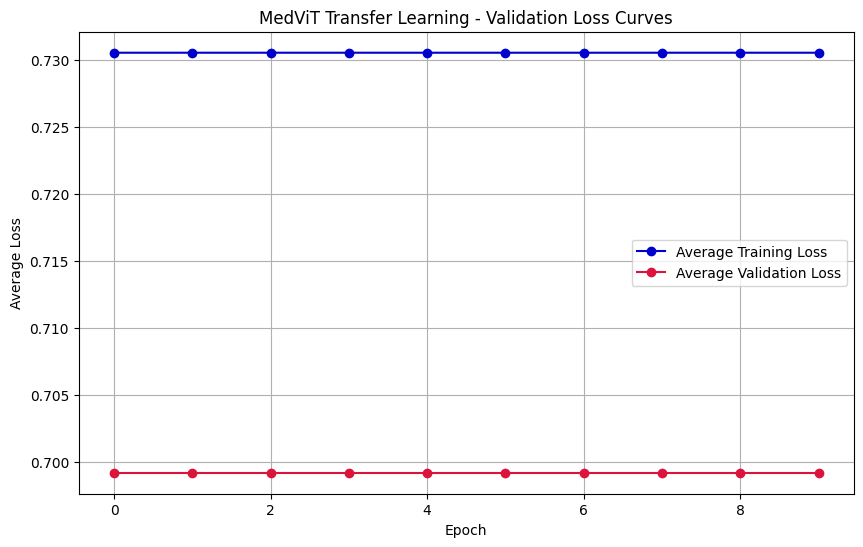

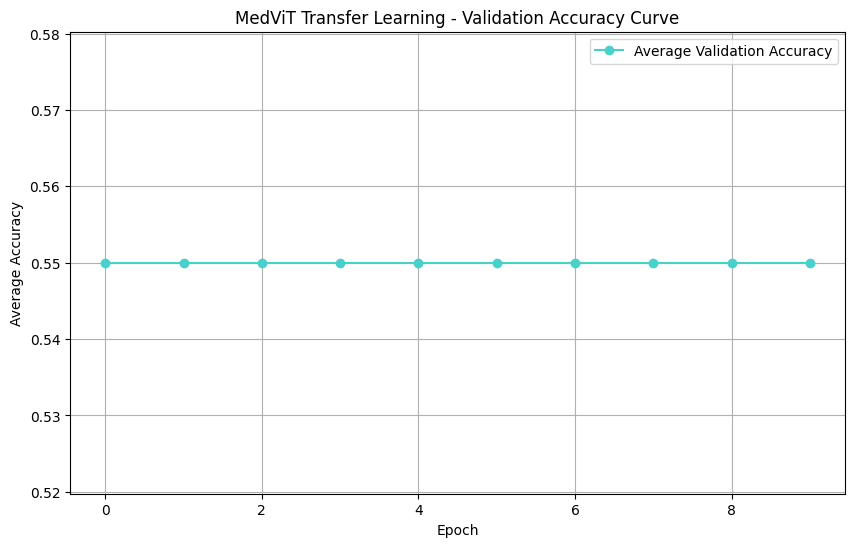

In [137]:
plot_multiple_splits_loss_curve(all_train_avg_loss_curves, all_valid_avg_loss_curves, title='MedViT Transfer Learning')

plot_multiple_splits_accuracy_curve(all_avg_accuracies_curves, title='MedViT Transfer Learning')